# Intro to ML: KNN

[Ссылка на теорию](https://web.archive.org/web/20221002034553/http://machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_(%D0%BA%D1%83%D1%80%D1%81_%D0%BB%D0%B5%D0%BA%D1%86%D0%B8%D0%B9%2C_%D0%9A.%D0%92.%D0%92%D0%BE%D1%80%D0%BE%D0%BD%D1%86%D0%BE%D0%B2)#.D0.9E.D1.81.D0.BD.D0.BE.D0.B2.D0.BD.D1.8B.D0.B5_.D0.BF.D0.BE.D0.BD.D1.8F.D1.82.D0.B8.D1.8F_.D0.B8_.D0.BF.D1.80.D0.B8.D0.BC.D0.B5.D1.80.D1.8B_.D0.BF.D1.80.D0.B8.D0.BA.D0.BB.D0.B0.D0.B4.D0.BD.D1.8B.D1.85_.D0.B7.D0.B0.D0.B4.D0.B0.D1.87).

## Содержание<a id="contents"></a>

* [Выборка](#samples)
* [Метод ближайшего соседа](#knn)
  * [Часть 1: "Просто" ближайший](#knn-1)
  * [Часть 2: Три ближайших](#knn-2)
* ["Обучение" параметров метода](#training)
* [Метод ближайшего соседа (продолжение)](#knn-continue)
  * [Часть 3: Обучаемый сосед](#knn-3)
  * [Часть 4: Честный обучаемый сосед](#knn-4)
  * [Часть 5: Честный обучаемый сосед без переобучения](#knn-5)
  * [Часть 6: "K" ближайших соседей](#knn-6)
* [Подбор гиперпараметров](#hyperparams)
* [Валидация](#validation)
  * [Часть 1: "Валидация" на train](#validation-1)
  * [Часть 2: Валидация на val](#validation-2)
  * [Часть 3: Валидация на разных val, или Кросс-валидация](#validation-3)

In [57]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt


SEED = 13112023

## Выборка<a id="samples"></a>

Пусть объекты — числа на прямой.

In [2]:
# Все-все объекты (полная совокупность)
X = np.arange(-3, 3.001, 0.01)

In [3]:
# Зависимость, которую будем пытаться найти
def a(x):
    return np.sin(x)

In [4]:
# Ответы для объектов
y = a(X)

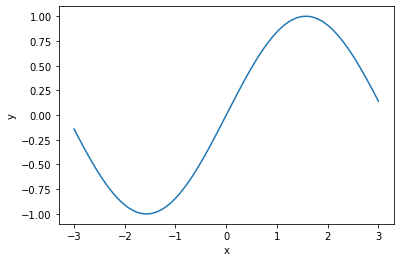

In [5]:
plt.plot(X, y)

plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [6]:
# Обучающая выборка (только для этих объектов будем знать ответы)
X_train = np.arange(-3, 3.001, 0.5)

In [7]:
np.random.seed(SEED)

# Знаем ответы, но с "шумом" ("как в реальной жизни")
noise = 0.2 * np.random.randn(len(X_train))
y_train = a(X_train) + noise

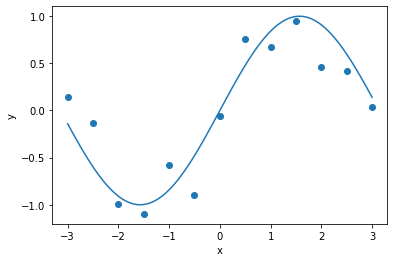

In [8]:
plt.plot(X, a(X))
plt.scatter(X_train, y_train)

plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Метод ближайшего соседа<a id="knn"></a>

[Ссылка на теорию](https://web.archive.org/web/20221002034553/http://machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_(%D0%BA%D1%83%D1%80%D1%81_%D0%BB%D0%B5%D0%BA%D1%86%D0%B8%D0%B9%2C_%D0%9A.%D0%92.%D0%92%D0%BE%D1%80%D0%BE%D0%BD%D1%86%D0%BE%D0%B2)#.D0.9C.D0.B5.D1.82.D1.80.D0.B8.D1.87.D0.B5.D1.81.D0.BA.D0.B8.D0.B5_.D0.BC.D0.B5.D1.82.D0.BE.D0.B4.D1.8B_.D0.BA.D0.BB.D0.B0.D1.81.D1.81.D0.B8.D1.84.D0.B8.D0.BA.D0.B0.D1.86.D0.B8.D0.B8_.D0.B8_.D1.80.D0.B5.D0.B3.D1.80.D0.B5.D1.81.D1.81.D0.B8.D0.B8).

### Часть 1: "Просто" ближайший<a id="knn-1"></a>

<div style="text-align: right">Назад к <a href=#contents>содержанию</a></div>

In [9]:
class NearestNeighbourModel:
    """
    Ответ для объекта — такой же, как у ближайшего соседа
    """

    def __init__(self, X: list, y: list):
        self.X = X
        self.y = y
    
    def predict(self, input: list) -> list:
        predictions = list()
        
        for x in input:
            distances = np.abs(self.X - x)
            index_nearest = np.argmin(distances)
            prediction = self.y[index_nearest]
            predictions.append(prediction)
        
        return predictions

In [10]:
model = NearestNeighbourModel(X_train, y_train)

y_pred = model.predict(X)

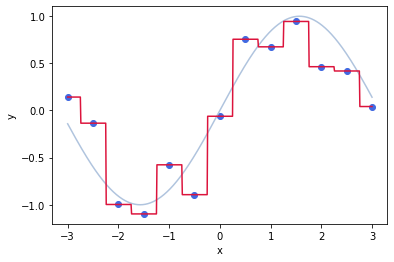

In [11]:
plt.plot(X, y, color='lightsteelblue')
plt.scatter(X_train, y_train, color='royalblue')

plt.plot(X, y_pred, color='crimson')

plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [12]:
def plot_prediction(X_target, y_pred, X_train, y_train):
    plt.plot(X, y, color='lightsteelblue')
    plt.scatter(X_train, y_train, color='royalblue')

    plt.plot(X_target, y_pred, color='crimson')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

### Часть 2: Три ближайших<a id="knn-2"></a>

<div style="text-align: right">Назад к <a href=#contents>содержанию</a></div>

In [13]:
class ThreeNearestNeighboursModel:
    def __init__(self, X, y, weights):
        self.X = X
        self.y = y
        
        self.weights = weights
    
    def predict(self, input: list) -> list:
        predictions = list()
        
        for x in input:
            distances = np.abs(self.X - x)
            indices_nearest = np.argsort(distances)
            
            prediction = (
                self.weights[0] * self.y[indices_nearest[0]]
                    + self.weights[1] * self.y[indices_nearest[1]]
                    + self.weights[2] * self.y[indices_nearest[2]]
            )

            predictions.append(prediction)
        
        return predictions

In [14]:
# Веса — "важности" соседей
# Считаем, что чем ближе, тем важнее
model = ThreeNearestNeighboursModel(
    X_train, y_train, weights=[0.6, 0.3, 0.1]
)

y_pred = model.predict(X)

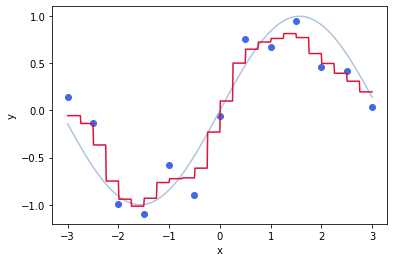

In [15]:
plot_prediction(X, y_pred, X_train, y_train)

Кажется, с тремя соседями стало получше...

Но откуда брать веса?
"С потолка"?..

## "Обучение" параметров метода<a id="training"></a>

<div style="text-align: right">Назад к <a href=#contents>содержанию</a></div>

По сетке: переберём "все" варианты и выберем лучшие веса.

In [16]:
divergences = list()
weight_grid = list()

grid_step = 0.05

for w1 in np.arange(0, 1.001, grid_step):
    for w2 in np.arange(0, 1.001 - w1, grid_step):
        w3 = 1 - (w1 + w2)  # пусть сумма весов равна единице
                            # (ответ — "усреднение" по ответам соседей)
        weights = (w1, w2, w3)

        model = ThreeNearestNeighboursModel(
            X_train, y_train, weights=weights
        )
        y_pred = model.predict(X)

        diffs = abs(y - y_pred)
        max_diff = max(diffs) 

        weight_grid.append(weights)
        divergences.append(max_diff)

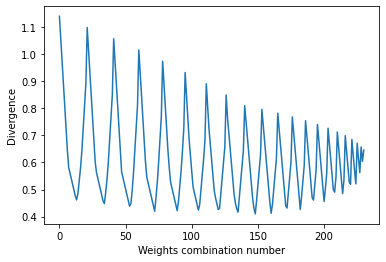

In [17]:
# График "плохости" метода в зависимости от номера комбинации весов
# (чем меньше, тем лучше)
plt.plot(divergences)

plt.xlabel('Weights combination number')
plt.ylabel('Divergence')

plt.show()

(График приведён в основном просто ради интереса — сделать из него определённые выводы не особо получается.)

In [18]:
# Лучшие веса
index_best = np.argmin(divergences)
weights_best = weight_grid[index_best]

print(f'Best weights: {weights_best} (index = {index_best}).')

Best weights: (0.4, 0.4, 0.19999999999999996) (index = 148).


## Метод ближайшего соседа (продолжение)<a id="knn-continue"></a>

### Часть 3: Обучаемый сосед<a id="knn-3"></a>

<div style="text-align: right">Назад к <a href=#contents>содержанию</a></div>

In [19]:
class ThreeTrainableNearestNeighboursModel:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
        self.k = 3
        
        # До обучения метод нельзя использовать
        # (но можно бы было и как-то более-менее нормально задать)
        self.weights = [None] * self.k
    
    def train(self):
        """
        Обучает веса метода (поиск по сетке).
        """
        divergences = list()
        weight_grid = list()

        grid_step = 0.05

        for w1 in np.arange(0, 1.001, grid_step):
            for w2 in np.arange(0, 1.001 - w1, grid_step):
                w3 = 1 - (w1 + w2)
                weights = (w1, w2, w3)

                model = ThreeNearestNeighboursModel(
                    self.X, self.y, weights=weights
                )

                y_pred = model.predict(X)
                diffs = abs(y - y_pred)
                max_diff = max(diffs) 

                weight_grid.append(weights)
                divergences.append(max_diff)
        
        index_best = np.argmin(divergences)
        weights_best = weight_grid[index_best]
        
        self.weights = weights_best
    
    def predict(self, input: list) -> list:
        predictions = list()
        
        for x in input:
            distances = np.abs(self.X - x)
            indices_nearest = np.argsort(distances)
            
            prediction = (
                self.weights[0] * self.y[indices_nearest[0]]
                    + self.weights[1] * self.y[indices_nearest[1]]
                    + self.weights[2] * self.y[indices_nearest[2]]
            )

            predictions.append(prediction)
        
        return predictions

In [20]:
model = ThreeTrainableNearestNeighboursModel(
    X_train, y_train
)

model.train()

print(f'Weights: {model.weights}.')

y_pred = model.predict(X)

Weights: (0.4, 0.4, 0.19999999999999996).


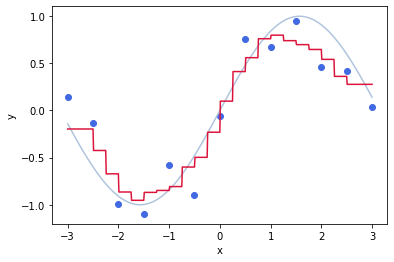

In [21]:
plot_prediction(X, y_pred, X_train, y_train)

Но метод выбирал веса, глядя на предсказание для *всей совокупности* объектов, а это нечестно — обучаться надо только по о*бучающей выборке*.

### Часть 4: Честный обучаемый сосед<a id="knn-4"></a>

<div style="text-align: right">Назад к <a href=#contents>содержанию</a></div>

In [22]:
class FairThreeTrainableNearestNeighboursModel:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
        self.k = 3
        self.weights = [None] * self.k
    
    def train(self):
        divergences = list()
        weight_grid = list()

        grid_step = 0.05

        for w1 in np.arange(0, 1.001, grid_step):
            for w2 in np.arange(0, 1.001 - w1, grid_step):
                w3 = 1 - (w1 + w2)
                weights = (w1, w2, w3)

                model = ThreeNearestNeighboursModel(
                    self.X, self.y, weights=weights
                )

                y_pred = model.predict(self.X)  # Теперь тут честно
                diffs = abs(self.y - y_pred)    # и тут тоже
                max_diff = max(diffs) 

                weight_grid.append(weights)
                divergences.append(max_diff)
        
        index_best = np.argmin(divergences)
        weights_best = weight_grid[index_best]
        
        self.weights = weights_best
    
    def predict(self, input: list) -> list:
        predictions = list()
        
        for x in input:
            distances = np.abs(self.X - x)
            indices_nearest = np.argsort(distances)
            
            prediction = (
                self.weights[0] * self.y[indices_nearest[0]]
                    + self.weights[1] * self.y[indices_nearest[1]]
                    + self.weights[2] * self.y[indices_nearest[2]]
            )

            predictions.append(prediction)
        
        return predictions

In [23]:
model = FairThreeTrainableNearestNeighboursModel(
    X_train, y_train
)

model.train()

print(f'Weights: {model.weights}.')

y_pred = model.predict(X)

Weights: (1.0, 0.0, 0.0).


Единичка, а остальные — нули?..

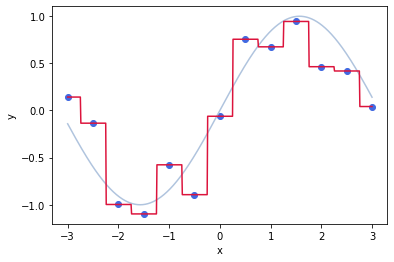

In [24]:
plot_prediction(X, y_pred, X_train, y_train)

"Угловато" — это явно не лучшее решение.
Но почему тогда обучились именно такие веса?..

### Часть 5: Честный обучаемый сосед без переобучения<a id="knn-5"></a>

<div style="text-align: right">Назад к <a href=#contents>содержанию</a></div>

Как и при изучении китайского так и тянет смотреть на пхиньинь вместо иероглифов, так и модели проще смотреть только на ближайшего соседа, ведь для объектов из обучающей выборки уже известны ответы (объект сам для себя и есть ближайший).

---

Переобучение — хорошее (очень хорошее) качество на обучающей выборке, но плохое — для остальных объектов.

In [25]:
class FairThreeTrainableNearestNeighboursNoOverfitModel:
    def __init__(self, X, y, weights=None):
        self.X = X
        self.y = y
        
        self.k = 3
        
        if weights is not None:
            self.weights = weights
        else:
            self.weights = [None] * self.k
    
    def train(self):
        divergences = list()
        weight_grid = list()

        grid_step = 0.05

        for w1 in np.arange(0, 1.001, grid_step):
            for w2 in np.arange(0, 1.001 - w1, grid_step):
                w3 = 1 - (w1 + w2)
                weights = (w1, w2, w3)

                model = FairThreeTrainableNearestNeighboursNoOverfitModel(
                    self.X, self.y, weights=weights
                )

                y_pred = model.predict(self.X, train=True)  # Отличие тут
                diffs = abs(self.y - y_pred)
                max_diff = max(diffs) 

                weight_grid.append(weights)
                divergences.append(max_diff)
        
        index_best = np.argmin(divergences)
        weights_best = weight_grid[index_best]
        
        self.weights = weights_best
    
    def predict(self, input: list, train=False) -> list:
        predictions = list()
        
        for x in input:
            distances = np.abs(self.X - x)
            indices_nearest = np.argsort(distances)
            
            if train:  # и тут
                indices_nearest = indices_nearest[1:]  # Замазываем пхиньинь

            prediction = (
                self.weights[0] * self.y[indices_nearest[0]]
                    + self.weights[1] * self.y[indices_nearest[1]]
                    + self.weights[2] * self.y[indices_nearest[2]]
            )

            predictions.append(prediction)
        
        return predictions

In [26]:
model = FairThreeTrainableNearestNeighboursNoOverfitModel(
    X_train, y_train
)

model.train()

print(f'Weights: {model.weights}.')

y_pred = model.predict(X)

Weights: (0.65, 0.35000000000000003, 0.0).


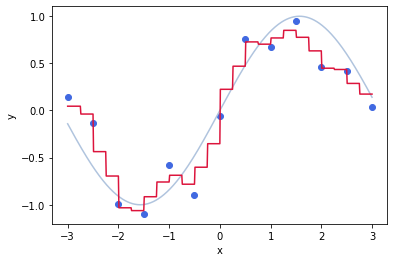

In [27]:
plot_prediction(X, y_pred, X_train, y_train)

### Часть 6: "K" ближайших соседей<a id="knn-6"></a>

<div style="text-align: right">Назад к <a href=#contents>содержанию</a></div>

In [28]:
class FairKTrainableNearestNeighboursNoOverfitModel:
    def __init__(self, X, y, k=None, weights=None):
        self.X = X
        self.y = y
        
        if k is None and weights is None:
            raise ValueError()

        if weights is not None:
            self.weights = weights
            self.k = len(self.weights)
        else:
            self.k = k
            self.weights = [None] * self.k
    
    def train(self):
        divergences = list()
        weight_grid = list()

        grid_step = 0.05
        eps = 1e-5
        grid = np.arange(0, 1.001, grid_step)

        # TODO: may take too much time
        for weights in product(grid, repeat=self.k):  # Отличие тут
            # Уберём ограничение на единичную сумму весов
            # Теперь это уже не усреднение
            # Будет дольше, но даём больше возможностей модели
            # (Проверено: без ограничения результат выходит получше)

            # if abs(1 - sum(weights)) > eps:
            #     continue

            model = FairKTrainableNearestNeighboursNoOverfitModel(
                self.X, self.y, weights=weights
            )

            y_pred = model.predict(self.X, train=True)
            diffs = abs(self.y - y_pred)
            max_diff = max(diffs) 

            weight_grid.append(weights)
            divergences.append(max_diff)
        
        index_best = np.argmin(divergences)
        weights_best = weight_grid[index_best]
        
        self.weights = weights_best
    
    def predict(self, input: list, train=False) -> list:
        predictions = list()
        
        for x in input:
            distances = np.abs(self.X - x)
            indices_nearest = np.argsort(distances)
            
            if train:
                indices_nearest = indices_nearest[1:]

            prediction = 0.0
            
            for i in range(self.k):  # и тут — теперь цикл работает для любого числа соседей
                prediction += (
                    self.weights[i] * self.y[indices_nearest[i]]
                )

            predictions.append(prediction)
        
        return predictions

In [29]:
model = FairKTrainableNearestNeighboursNoOverfitModel(
    X_train, y_train, k=1
)

model.train()

print(f'Weights: {model.weights}.')

y_pred = model.predict(X)

Weights: (1.0,).


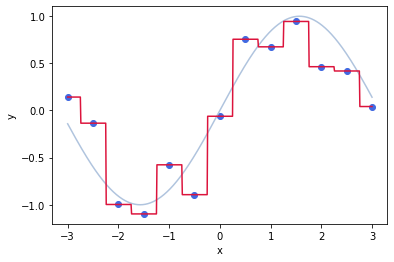

In [30]:
plot_prediction(X, y_pred, X_train, y_train)

In [31]:
model = FairKTrainableNearestNeighboursNoOverfitModel(
    X_train, y_train, k=3
)

model.train()

print(f'Weights: {model.weights}.')

y_pred = model.predict(X)

Weights: (0.55, 0.35000000000000003, 0.0).


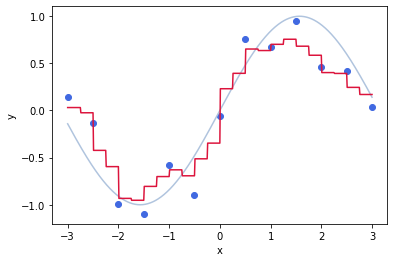

In [32]:
plot_prediction(X, y_pred, X_train, y_train)

## Подбор гиперпараметров<a id="hyperparams"></a>

<div style="text-align: right">Назад к <a href=#contents>содержанию</a></div>

Число соседей — определяет веса.
Веса сделали обучаемыми.
Но откуда брать само число соседей?..

---

Гиперпараметры — параметры, задающие параметры.

In [33]:
# Перепишем класс, добавив ещё один параметр — шаг сетки.
# Ведь при большом числе соседей искать веса на малой сетке
# может оказаться очень долго...
# (и надо, чтоб была возможность немного "схалтурить")
#
# P.S.
# В целях более понятного "потока" изложения
# решено было пожертвовать некоторыми "правилами" написания кода,
# в частности "правилом DRY", ведь код далее —
# это явный почти копипаст класса выше.
# Вообще же так копировать не очень хорошо!

class FairKTrainableNearestNeighboursNoOverfitModel:
    def __init__(self, X, y, k=None, weights=None, grid_step=0.05):
        self.X = X
        self.y = y
        
        if k is None and weights is None:
            raise ValueError()

        if weights is not None:
            self.weights = weights
            self.k = len(self.weights)
        else:
            self.k = k
            self.weights = [None] * self.k
        
        self.grid_step = grid_step
        self.eps = 1e-5
    
    def train(self):
        divergences = list()
        weight_grid = list()

        grid = np.arange(0, 1.001, self.grid_step)

        # TODO: for big k, may be too long
        for weights in product(grid, repeat=self.k):
            # if abs(1 - sum(weights)) > self.eps:
            #     continue

            model = FairKTrainableNearestNeighboursNoOverfitModel(
                self.X, self.y, weights=weights
            )

            y_pred = model.predict(self.X, train=True)
            diffs = abs(self.y - y_pred)
            max_diff = max(diffs) 

            weight_grid.append(weights)
            divergences.append(max_diff)
        
        index_best = np.argmin(divergences)
        weights_best = weight_grid[index_best]
        
        self.weights = weights_best
    
    def predict(self, input: list, train=False) -> list:
        predictions = list()
        
        for x in input:
            distances = np.abs(self.X - x)
            indices_nearest = np.argsort(distances)
            
            if train:
                indices_nearest = indices_nearest[1:]

            prediction = 0.0
            
            for i in range(self.k):
                prediction += (
                    self.weights[i] * self.y[indices_nearest[i]]
                )

            predictions.append(prediction)
        
        return predictions

In [34]:
grid_step = 0.05
divergences = dict()

for k in range(1, 10):
    print(f'K = {k}.')
    
    # Меняем сетку в зависимости от числа соседей k.
    # Это не очень честно, но лучше так,
    # чем вообще никогда не дождаться результата :)

    if k == 5:
        grid_step = 0.1
    elif k == 6 or k == 7:
        grid_step = 0.2
    elif k >= 8:
        grid_step = 0.5
    
    model = FairKTrainableNearestNeighboursNoOverfitModel(
        X_train, y_train, k=k, grid_step=grid_step
    )
    
    model.train()

    y_pred = model.predict(X)
    diffs = abs(y - y_pred)
    max_diff = max(diffs)
    
    divergences[k] = max_diff

K = 1.
K = 2.
K = 3.
K = 4.
K = 5.
K = 6.
K = 7.
K = 8.
K = 9.


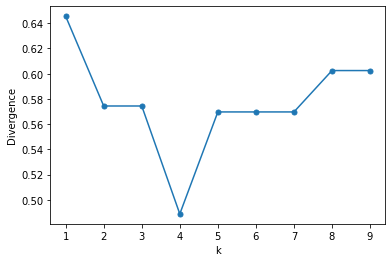

In [35]:
# "Плохость" в зависимости от k
plt.plot(
    divergences.keys(), divergences.values(),
    marker='.', markersize=10
)

plt.xlabel('k')
plt.ylabel('Divergence')
plt.show()

In [36]:
best_k_index = np.argmin(list(divergences.values()))
best_k = list(divergences.keys())[best_k_index]

print(f'Best k = {best_k}.')

model = FairKTrainableNearestNeighboursNoOverfitModel(
    X_train, y_train, k=best_k_index  # TODO: тут опечатка, но лень перезапускать :)
)

model.train()

print(f'Weights: {model.weights}.')

y_pred = model.predict(X)

Best k = 4.
Weights: (0.55, 0.35000000000000003, 0.0).


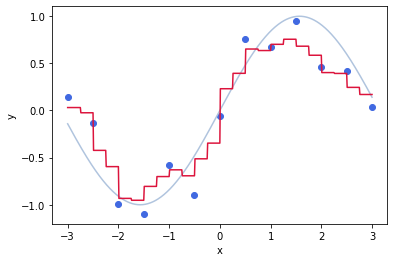

In [37]:
plot_prediction(X, y_pred, X_train, y_train)

Таким образом, подбор гиперпараметра `k` сейчас завязан на то, какой хорошей получится модель при данном `k`.
При это качество оценивается на всей совокупности объектов...
Но ведь это не честно — потому что считаем, что в распоряжении есть только обучающая выборка!

## Валидация<a id="validation"></a>

### Часть 1: "Валидация" на train<a id="validation-1"></a>

<div style="text-align: right">Назад к <a href=#contents>содержанию</a></div>

Качество обученной модели будем смотреть на "имеющейся в распоряжении" обучающей выборке.

In [38]:
grid_step = 0.05
divergences = dict()

for k in range(1, 10):
    print(f'K = {k}.')
    
    if k == 5:
        grid_step = 0.1
    elif k == 6 or k == 7:
        grid_step = 0.2
    elif k >= 8:
        grid_step = 0.5
    
    model = FairKTrainableNearestNeighboursNoOverfitModel(
        X_train, y_train, k=k, grid_step=grid_step
    )
    
    model.train()

    y_pred = model.predict(X_train)  # Отличие тут
    diffs = abs(y_train - y_pred)    # и тут
    max_diff = max(diffs)
    
    divergences[k] = max_diff

K = 1.
K = 2.
K = 3.
K = 4.
K = 5.
K = 6.
K = 7.
K = 8.
K = 9.


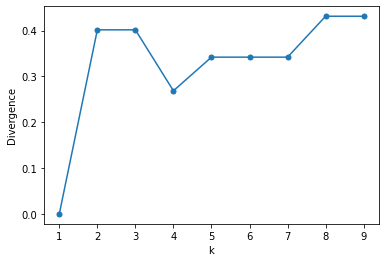

In [39]:
# "Плохость" в зависимости от k
plt.plot(
    divergences.keys(), divergences.values(),
    marker='.', markersize=10
)

plt.xlabel('k')
plt.ylabel('Divergence')
plt.show()

Лучший `k` — это один сосед?..

Подбор гиперпараметра `k` завязан на то, какой хорошей получится модель при данном `k`.
При это качество оценивается на обучающей выборке.
Это честно, но, выходит, лучший `k` — это такой, при котором модель лучше всего обучилась... или переобучилась?..
Хороший ли это тогда это поиск `k`?

### Часть 2: Валидация на val<a id="validation-2"></a>

<div style="text-align: right">Назад к <a href=#contents>содержанию</a></div>

Или "Валидация без переобучения под train".

Качество обученной модели лучше смотреть на *отложенной выборке*, которая не использовалась для обучения.
Таким образом, будем смотреть именно на качество, а не на "уровень переобученности".

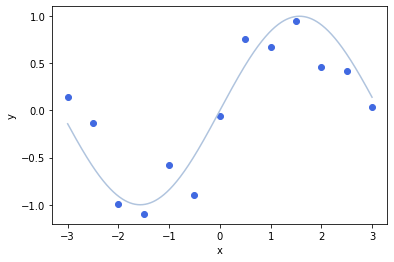

In [40]:
# Вспомним, как выглядит обучающая выборка
plt.plot(X, y, color='lightsteelblue')
plt.scatter(X_train, y_train, color='royalblue')

plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [41]:
print(f'Всего объектов в X_train: {len(X_train)}.')

Всего объектов в X_train: 13.


Отложим 3 объекта для валидации (возьмём из начала, из конца, и из середины).

In [42]:
X_val = np.array(
    [X_train[0], X_train[7], X_train[-1]]
)
y_val = np.array(
    [y_train[0], y_train[7], y_train[-1]]
)

X_train = np.array(
    list(X_train[1:7]) + list(X_train[8:-1])
)
y_train = np.array(
    list(y_train[1:7]) + list(y_train[8:-1])
)

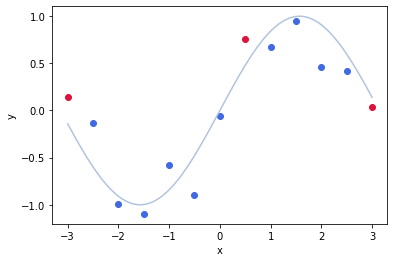

In [43]:
# X_train и X_val
plt.plot(X, y, color='lightsteelblue')
plt.scatter(X_train, y_train, color='royalblue')
plt.scatter(X_val, y_val, color='crimson')

plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [44]:
grid_step = 0.05
divergences = dict()

for k in range(1, 10):
    print(f'K = {k}.')
    
    if k == 5:
        grid_step = 0.1
    elif k == 6 or k == 7:
        grid_step = 0.2
    elif k >= 8:
        grid_step = 0.5
    
    model = FairKTrainableNearestNeighboursNoOverfitModel(
        X_train, y_train, k=k, grid_step=grid_step
    )
    
    model.train()

    y_pred = model.predict(X_val)  # Отличие тут
    diffs = abs(y_val - y_pred)    # и тут
    max_diff = max(diffs)
    
    divergences[k] = max_diff

K = 1.
K = 2.
K = 3.
K = 4.
K = 5.
K = 6.
K = 7.
K = 8.
K = 9.


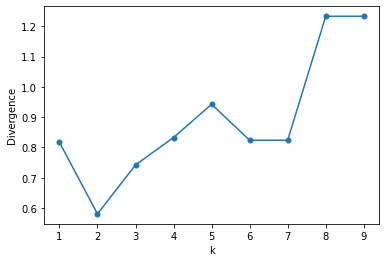

In [45]:
# "Плохость" в зависимости от k
plt.plot(
    divergences.keys(), divergences.values(),
    marker='.', markersize=10
)

plt.xlabel('k')
plt.ylabel('Divergence')
plt.show()

Теперь `k`, равный одному соседу, не является лучшим!

Кажется, что всё и честно, и работает.
Лучший `k` — такой, при котором модель показывает лучшее качество на отложенной выборке.
То есть модель в самом деле хорошая, или... просто лучше всего смогла "подстроиться" под отложенную выборку?..

### Часть 3: Валидация на разных val, или Кросс-валидация<a id="validation-3"></a>

<div style="text-align: right">Назад к <a href=#contents>содержанию</a></div>

Или "Валидация без переобучения под val".

Качество обученной модели снова будем смотреть на *отложенной выборке*, но эту отложенную будем выбирать несколько раз: и чтобы избежать эффектов, вызванных случайностью выбора отложенной выборки (вдруг модель плохая, просто на данном X_val смогла почему-то хорошо себя показать), и чтобы избежать "подстройки" под X_val (хотим лучшую модель вообще, а не только на данном X_val).

In [46]:
# Восстановим обучающую выборку
X_train = np.arange(-3, 3.001, 0.5)

In [47]:
np.random.seed(SEED)

noise = 0.2 * np.random.randn(len(X_train))
y_train = a(X_train) + noise

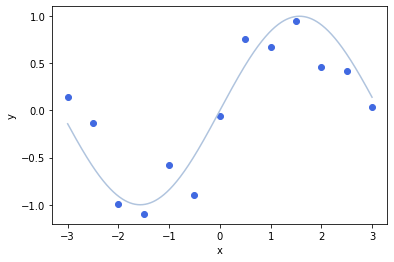

In [48]:
plt.plot(X, y, color='lightsteelblue')
plt.scatter(X_train, y_train, color='royalblue')

plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [58]:
np.random.seed(SEED)

num_val_samples = 3
results = list()

for i in range(10):
    print(f'Iteration: {i}.')
    
    val_indices = np.random.choice(
        range(len(X_train)), num_val_samples, replace=False
    )
    
    X_val_i = np.array(
        [X_train[j] for j in val_indices]
    )
    y_val_i = np.array(
        [y_train[j] for j in val_indices]
    )

    X_train_i = np.array(
        [X_train[j] for j in range(len(X_train))
                    if j not in val_indices]
    )
    y_train_i = np.array(
        [y_train[j] for j in range(len(X_train))
                    if j not in val_indices]
    )
    
    grid_step = 0.05
    divergences = dict()

    for k in range(1, 10):
        print(f'    K = {k}.')

        if k == 5:
            grid_step = 0.1
        elif k == 6 or k == 7:
            grid_step = 0.2
        elif k >= 8:
            grid_step = 0.5

        model = FairKTrainableNearestNeighboursNoOverfitModel(
            X_train_i, y_train_i,          # Отличие тут
            k=k, grid_step=grid_step
        )

        model.train()

        y_pred_i = model.predict(X_val_i)  # и тут
        diffs = abs(y_val_i - y_pred_i)    # и тут
        max_diff = max(diffs)

        divergences[k] = max_diff
    
    results.append(divergences)

Iteration: 0.
    K = 1.
    K = 2.
    K = 3.
    K = 4.
    K = 5.
    K = 6.
    K = 7.
    K = 8.
    K = 9.
Iteration: 1.
    K = 1.
    K = 2.
    K = 3.
    K = 4.
    K = 5.
    K = 6.
    K = 7.
    K = 8.
    K = 9.
Iteration: 2.
    K = 1.
    K = 2.
    K = 3.
    K = 4.
    K = 5.
    K = 6.
    K = 7.
    K = 8.
    K = 9.
Iteration: 3.
    K = 1.
    K = 2.
    K = 3.
    K = 4.
    K = 5.
    K = 6.
    K = 7.
    K = 8.
    K = 9.
Iteration: 4.
    K = 1.
    K = 2.
    K = 3.
    K = 4.
    K = 5.
    K = 6.
    K = 7.
    K = 8.
    K = 9.
Iteration: 5.
    K = 1.
    K = 2.
    K = 3.
    K = 4.
    K = 5.
    K = 6.
    K = 7.
    K = 8.
    K = 9.
Iteration: 6.
    K = 1.
    K = 2.
    K = 3.
    K = 4.
    K = 5.
    K = 6.
    K = 7.
    K = 8.
    K = 9.
Iteration: 7.
    K = 1.
    K = 2.
    K = 3.
    K = 4.
    K = 5.
    K = 6.
    K = 7.
    K = 8.
    K = 9.
Iteration: 8.
    K = 1.
    K = 2.
    K = 3.
    K = 4.
    K = 5.
    K = 6.
    K = 7.
    K

In [59]:
results[:2]

[{1: 0.316751635316621,
  2: 0.316751635316621,
  3: 0.8888923777237812,
  4: 1.0274218143357428,
  5: 1.0531752163559962,
  6: 0.7532093990205911,
  7: 0.7532093990205911,
  8: 0.31274311943747946,
  9: 0.31274311943747946},
 {1: 0.7804020372626753,
  2: 0.7128501624761201,
  3: 0.7128501624761201,
  4: 0.7128501624761201,
  5: 0.7128501624761201,
  6: 1.7792381006283482,
  7: 1.7792381006283482,
  8: 0.7865168055115637,
  9: 1.1054449657998113}]

In [60]:
averaged_divergences = dict()

for k in results[0]:
    averaged_divergences[k] = (
        sum(r[k] for r in results) / len(results)
    )

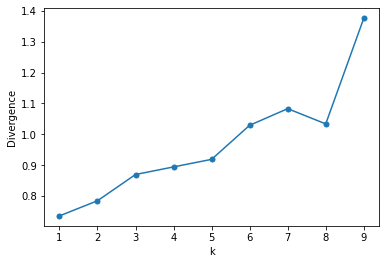

In [61]:
# "Плохость" в зависимости от k
plt.plot(
    averaged_divergences.keys(),
    averaged_divergences.values(),
    marker='.', markersize=10
)

plt.xlabel('k')
plt.ylabel('Divergence')
plt.show()

Оптимальный `k` равен... одному?
Но ведь это точно плохая модель?

Видимо, `k = 1` оказался просто самым устойчивым относительно "пертурбаций" в выборках train и val: они были очень маленькие, поэтому и val мог состоять из "нерепрезентативных" объектов (например, все с одного края), и из train мог быть вырезан "важный кусок".

Поэтому... проведём ещё один эксперимент, в этом же разделе, но с выборкой "нормального" размера.

In [63]:
print(f'Старое количество объектов в train: {len(X_train)}.')

Старое количество объектов в train: 13.


In [64]:
X_train = np.arange(-3, 3.001, 0.02)

In [65]:
print(f'Новое количество объектов в train: {len(X_train)}.')

Новое количество объектов в train: 301.


In [66]:
np.random.seed(SEED)

noise = 0.2 * np.random.randn(len(X_train))
y_train = a(X_train) + noise

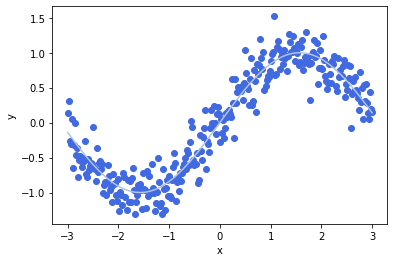

In [67]:
plt.plot(X, y, color='lightsteelblue')
plt.scatter(X_train, y_train, color='royalblue')

plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [69]:
np.random.seed(SEED)

num_val_samples = int(0.25 * len(X_train))
results = list()

for i in range(10):
    print(f'Iteration: {i}.')
    
    val_indices = np.random.choice(
        range(len(X_train)), num_val_samples, replace=False
    )
    
    X_val_i = np.array(
        [X_train[j] for j in val_indices]
    )
    y_val_i = np.array(
        [y_train[j] for j in val_indices]
    )

    X_train_i = np.array(
        [X_train[j] for j in range(len(X_train))
                    if j not in val_indices]
    )
    y_train_i = np.array(
        [y_train[j] for j in range(len(X_train))
                    if j not in val_indices]
    )
    
    grid_step = 0.05
    divergences = dict()

    for k in range(1, 10):
        print(f'    K = {k}.')

        if k == 3:
            grid_step = 0.1
        elif k == 4 or k == 5:
            grid_step = 0.2
        elif k >= 6:
            grid_step = 0.5

        model = FairKTrainableNearestNeighboursNoOverfitModel(
            X_train_i, y_train_i,
            k=k, grid_step=grid_step
        )

        model.train()

        y_pred_i = model.predict(X_val_i)
        diffs = abs(y_val_i - y_pred_i)
        max_diff = max(diffs)

        divergences[k] = max_diff
    
    results.append(divergences)

Iteration: 0.
    K = 1.
    K = 2.
    K = 3.
    K = 4.
    K = 5.
    K = 6.
    K = 7.
    K = 8.
    K = 9.
Iteration: 1.
    K = 1.
    K = 2.
    K = 3.
    K = 4.
    K = 5.
    K = 6.
    K = 7.
    K = 8.
    K = 9.
Iteration: 2.
    K = 1.
    K = 2.
    K = 3.
    K = 4.
    K = 5.
    K = 6.
    K = 7.
    K = 8.
    K = 9.
Iteration: 3.
    K = 1.
    K = 2.
    K = 3.
    K = 4.
    K = 5.
    K = 6.
    K = 7.
    K = 8.
    K = 9.
Iteration: 4.
    K = 1.
    K = 2.
    K = 3.
    K = 4.
    K = 5.
    K = 6.
    K = 7.
    K = 8.
    K = 9.
Iteration: 5.
    K = 1.
    K = 2.
    K = 3.
    K = 4.
    K = 5.
    K = 6.
    K = 7.
    K = 8.
    K = 9.
Iteration: 6.
    K = 1.
    K = 2.
    K = 3.
    K = 4.
    K = 5.
    K = 6.
    K = 7.
    K = 8.
    K = 9.
Iteration: 7.
    K = 1.
    K = 2.
    K = 3.
    K = 4.
    K = 5.
    K = 6.
    K = 7.
    K = 8.
    K = 9.
Iteration: 8.
    K = 1.
    K = 2.
    K = 3.
    K = 4.
    K = 5.
    K = 6.
    K = 7.
    K

In [70]:
results[:2]

[{1: 1.1434181894416529,
  2: 0.8775706359116178,
  3: 0.8423206433344872,
  4: 0.8262676623871623,
  5: 0.8041365691124901,
  6: 0.7474585045450589,
  7: 0.7474585045450589,
  8: 0.692267915013613,
  9: 0.692267915013613},
 {1: 0.69826279850918,
  2: 0.6149442276376405,
  3: 0.6196380407080689,
  4: 0.6226455378425525,
  5: 0.5717070847796764,
  6: 0.7024501737585152,
  7: 0.7024501737585152,
  8: 0.7024501737585152,
  9: 0.7024501737585152}]

In [71]:
averaged_divergences = dict()

for k in results[0]:
    averaged_divergences[k] = (
        sum(r[k] for r in results) / len(results)
    )

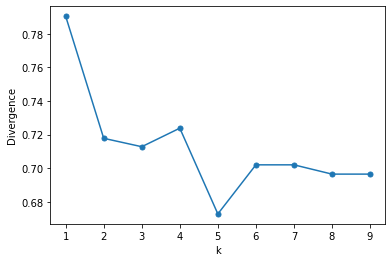

In [72]:
# "Плохость" в зависимости от k
plt.plot(
    averaged_divergences.keys(),
    averaged_divergences.values(),
    marker='.', markersize=10
)

plt.xlabel('k')
plt.ylabel('Divergence')
plt.show()

Видим, что `k = 1` хуже всех (ожидаемо), а лучший — это `k = 5` (раньше же, при "валидации" на всей совокупности, но с малой обучающей выборкой, лучшее `k` получилось `k = 4`, то есть похоже).

Интереса ради посмотрим на лучшего на картинке.

In [75]:
best_k_index = np.argmin(list(averaged_divergences.values()))
best_k = list(averaged_divergences.keys())[best_k_index]

print(f'Best k = {best_k}.')

model = FairKTrainableNearestNeighboursNoOverfitModel(
    X_train, y_train, k=best_k,
    grid_step=0.2
)

model.train()

print(f'Weights: {model.weights}.')

y_pred = model.predict(X)

Best k = 5.
Weights: (0.4, 0.0, 0.0, 0.2, 0.4).


Интересно, второй и третий не важны, а пятый так же важен, как первый... 🤔

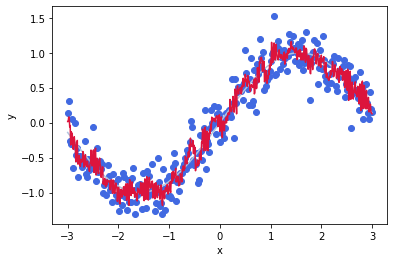

In [78]:
plot_prediction(X, y_pred, X_train, y_train)

## P.S.

Копипаст, и все эти "отличие тут, и тут" — так делать не надо!
Это была лишь попытка сделать ноутбук, пусть и немного "похуже" в плане качества кода, но, возможно, более простым и понятным (возможно).

Другая версия того же сюжета о KNN: https://github.com/Alvant/AdvancedPython/blob/master2022/labs/lab24/demo/ML2.ipynb.
Которая, по мнению автора, получилась более "замороченной" (зато там красивые картинки 🙂).